<h1 style="font-size:42px; text-align:center; margin-bottom:30px;"><span style="color:SteelBlue">Step 2
:</span> ABT Construction</h1>
<hr>

We shall do solid **Data Cleaning** and **Feature Engineering** to our dataset,

Because **better data beats better algorithms**.

essential tasks for building an analytical base table:
1. [Drop unwanted observations](#drop)
2. [Fix structural errors](#structural)
3. [Handle missing data](#missing-data)
4. [Engineer features](#engineer-features)
5. [Save the ABT](#save-abt)



In [1]:
# import our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Load employee data from CSV
data = pd.read_csv('project_files/employee_data.csv')

time to clean the data

# 1. Drop wanted observations

<br>
**First, <span style="color:royalblue">drop duplicates</span> from the dataset.**

In [3]:
# Drop duplicates
data.drop_duplicates()
data.shape

(14249, 10)

** Our objective is to predict whether an <code style="color:steelblue">employee</code> stays or leaves.
Thus we should drop non-employees from our dataset**

In [4]:
# Drop temporary workers
data = data[data.department != 'temp']
data.shape

(14068, 10)

<span id="structural"></span>
# 2. Fix structural errors

next step of data cleaning is fixing structural errors like our NaN's in filed_complaint and recently_promoted features
 - which arise during measurement, data transfer, or other types of "poor housekeeping."


In [6]:
# Print unique values of 'filed_complaint'
print(data.filed_complaint.unique())
# Print unique values of 'recently_promoted'
print(data.recently_promoted.unique())

[ nan   1.]
[ nan   1.]


In [7]:
# Missing filed_complaint values should be 0
data.filed_complaint = data.filed_complaint.fillna(0)
# Missing recently_promoted values should be 0
data.recently_promoted = data.recently_promoted.fillna(0)

**Plot class distributions for 'department' to check for possible errors or duplicate classes **

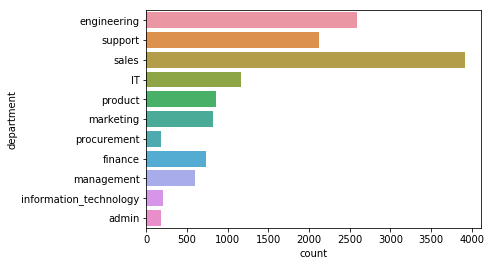

In [10]:
sns.countplot(y='department', data=data)

In [11]:
# 'information_technology' should be 'IT'
data.department.replace('information_technology', 'IT', inplace=True)

# 3. Handle missing data

time to handle any **missing data**. 

**Display the <span style="color:royalblue">number of missing values</span> for each feature (both categorical and numeric).**

In [12]:
# Display number of missing values by feature
data.isnull().sum()

avg_monthly_hrs         0
department            709
filed_complaint         0
last_evaluation      1351
n_projects              0
recently_promoted       0
salary                  0
satisfaction            0
status                  0
tenure                  0
dtype: int64

In [13]:
# Fill missing values in department with 'Missing'
data.department.fillna('Missing', inplace=True)

**Let's flag <code style="color:steelblue">'last_evaluation'</code> with an indicator variable of missingness.** 
* <code style="color:crimson">0</code> if not missing.
* <code style="color:crimson">1</code> if missing.

In [25]:
# Indicator variable for observations missing last_evaluation
data.last_evaluation_missing = data.last_evaluation.isnull().astype(int)

In [26]:
# Fill missing values in last_evaluation with 0
data.last_evaluation.fillna(0, inplace=True)

**Display the number of missing values for each feature (both categorical and numeric) again, to confirm non NaN's are present.**

In [27]:
# Display number of missing values by feature
data.isnull().sum()

avg_monthly_hrs      0
department           0
filed_complaint      0
last_evaluation      0
n_projects           0
recently_promoted    0
salary               0
satisfaction         0
status               0
tenure               0
dtype: int64

# 4. Engineer features

From our exploratory data analysis, we saw thatth scatterplot for <code style="color:steelblue">'satisfaction'</code> and <code style="color:steelblue">'last_evaluation'</code> for employees who have <code style="color:crimson">'Left'</code> had clusters and showed certain features themsleves.

**Let's reproduce that scatterplot**

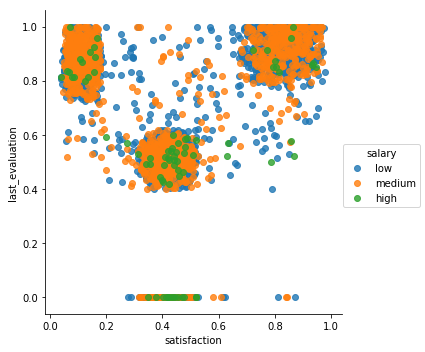

In [28]:
# Scatterplot of satisfaction vs. last_evaluation, only those who have left
data_mask = data[data['status'] == 'Left']
sns.lmplot(x='satisfaction', y='last_evaluation', data=data_mask, hue='salary', fit_reg=False)

Behaviorally we can engineer these three clusters (groups) into 3 **indicator features** :

* <code style="color:steelblue">'mediocre'</code> - last_evaluation < 0.6 and last_evaluation_missing == 0
* <code style="color:steelblue">'frustrated'</code> - satisfaction_level < 0.2
* <code style="color:steelblue">'ambitious'</code> - last_evaluation > 0.8 and satisfaction > 0.7

* **Important:** For <code style="color:steelblue">'underperformer'</code>, it's important to include <code style="color:steelblue">'last_evaluation_missing' == 0</code> to avoid those originally missing observations that we flagged and filled.

In [31]:
# Create new indicator features (super cool!)
data['mediocre'] = ((data.last_evaluation < 0.6) & (data.last_evaluation_missing == 0)).astype(int)
data['frustrated'] = (data.satisfaction < 0.2) .astype(int)
data['ambitious'] = ((data.last_evaluation >0.8) & (data.satisfaction > 0.7)).astype(int)

**check that we indeed created the features, and did so correctly.**

In [34]:
# The proportion of observations belonging to each group
data[['mediocre', 'frustrated', 'ambitious']].mean()

mediocre      0.381291
frustrated    0.092195
ambitious     0.177069
dtype: float64

# 5. Save the ABT

Always save your cleaned and engineered **analytical base table**. 

Avoiding <code style="color:red">ze EviL</code> dummy varaible <code style="color:crimson">TRAP</code>!

**Let's convert <code style="color:steelblue">'status'</code> feature into an indicator variable seperately as we want explicitly:**
* <code style="color:crimson">'Left'</code> to be <code style="color:crimson">1</code> - we are aiming our model to see whether it can predict if an employee left or not
  
* <code style="color:crimson">'Employed'</code> to be <code style="color:crimson">0</code>

In [52]:
 # Convert status to an indicator variable, with left as 1
data['status'] = pd.get_dummies(data.status)

**check the proportion of people in our dataset who left to see if our dummies held strong**

In [42]:
# The proportion of observations who 'Left'
data['status'].sum() / data.count()[1]

0.23933750355416547

**Now let's do the <span style="color:royalblue">dummy variables</span> for the rest of the categorical features, where we do not need an explicit value for each dummy as we did for our target variable <span style="color:crimson">'status'</span> **

In [44]:
# Create new dataframe with dummy features
data = pd.get_dummies(data, columns=['department', 'salary'])
# Display our data to confirm all dummy changes were made
data.head(10)

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,status,tenure,mediocre,frustrated,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,1,5.0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,0,2.0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,0,3.0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,0,2.0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,0,3.0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,140,0.0,0.589097,4,0.0,0.660020,0,4.0,1,0,...,0,0,0,0,0,1,0,0,0,1
6,121,1.0,0.625399,3,0.0,0.835571,0,3.0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,150,0.0,0.644586,4,0.0,0.796683,0,3.0,0,0,...,0,0,0,0,0,0,0,0,1,0
8,215,1.0,0.524114,3,0.0,0.715005,0,7.0,1,0,...,0,0,0,0,0,0,0,0,0,1
9,269,0.0,0.909364,5,0.0,0.994037,0,2.0,0,0,...,0,0,0,0,0,0,1,0,0,1


**Good to go**

In [45]:
# Save analytical base table
data.to_csv('analytical_base_table.csv', index=None)

**Recap, the essential steps to construct our analytical base table:**

**The Data Clean: **
* Drop irrelevant observations from the dataset.
* Find and Fix the various structural errors, such as wannabe indicator variables.
* Handle the missing data appropriately.

**The Feature Engineering:**
* Engineer new features by your conclusions from the exploratory analysis and artistic mind's eye.
* Create dummy variables for your categorical types
* Save the ABT.
